##### Modeling: Predict total_sales

- To load the data from end of EDA process, and to compare the results by traditional machining (RandomForest) and MLP

- Save the model

In [1]:
# load the data 
import pandas as pd
df = pd.read_csv('df_with_sentiment.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6208 entries, 0 to 6207
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             6208 non-null   int64  
 1   title                  6208 non-null   object 
 2   platform               6208 non-null   object 
 3   releaseDate            6208 non-null   object 
 4   rating                 6208 non-null   object 
 5   genres                 6208 non-null   object 
 6   quote                  6208 non-null   object 
 7   score                  6208 non-null   float64
 8   total_sales            6208 non-null   float64
 9   original_price         6208 non-null   float64
 10  release_year           6208 non-null   int64  
 11  release_quarter        6208 non-null   int64  
 12  release_month          6208 non-null   int64  
 13  processed_tokens       6208 non-null   object 
 14  clean_text_stemmed     6184 non-null   object 
 15  clea

##### There are a few models will be run:
1) Simple Linear Regression
2) Random Foreast 
3) Random Foreast (with adjusted parameters)
4) MLP

In [2]:
#Simple Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer



# Choose X, y coulmns
X = df.drop(['Unnamed: 0','title', 'quote', 'releaseDate', 'total_sales', 'processed_tokens',
              'clean_text_stemmed', 'clean_text_lemmatized', 'entities', 'frequency', 
              'sentiment'], axis=1, errors='ignore')
X = pd.get_dummies(X, columns=['platform', 'rating', 'genres', 'predicted_sentiment'], drop_first=True)

y = df['total_sales']



print(X.shape)

# to check missing value (need imputation?)
missing_values_count = X.isnull().sum()
print(f"Missing values in each feature before imputation: {missing_values_count}")
print("Missing values in each feature before imputation:")
print(missing_values_count[missing_values_count > 0])

# (N needed )Impute Missing value for X??
#imputer = SimpleImputer(strategy='median')
#X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Spilt data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modeling : LinearRegression
model = LinearRegression()

# RMSE definition : --> cross_ val_score does not have RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Cross_validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)
cv_r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# fit the model
model.fit(X_train, y_train)

# Prediction and Evaluation
y_pred = model.predict(X_test)




print(f"Model 0: LinearRegression")

print(f"Cross-Validation RMSE scores in training set: {cv_scores}")
print("Mean RMSE in training set:", cv_scores.mean())
print("RMSE in testing set:", mean_squared_error(y_test, y_pred, squared=False))



print("Cross-validated R² scores in training set:", cv_r2_scores)
print("Mean R² score in training set:", cv_r2_scores.mean())
print("R² score in testing set:", r2_score(y_test, model.predict(X_test)))


(6208, 50)
Missing values in each feature before imputation: score                             0
original_price                    0
release_year                      0
release_quarter                   0
release_month                     0
sentiment_score                   0
rating_E10+                       0
rating_M                          0
rating_T                          0
genres_2D Platformer              0
genres_3D Beat-'Em-Up             0
genres_3D Fighting                0
genres_3D Platformer              0
genres_4X Strategy                0
genres_Action                     0
genres_Action Adventure           0
genres_Action Puzzle              0
genres_Action RPG                 0
genres_Application                0
genres_Auto Racing                0
genres_Auto Racing Sim            0
genres_Basketball                 0
genres_Basketball Sim             0
genres_Compilation                0
genres_Dancing                    0
genres_FPS                        0
gen

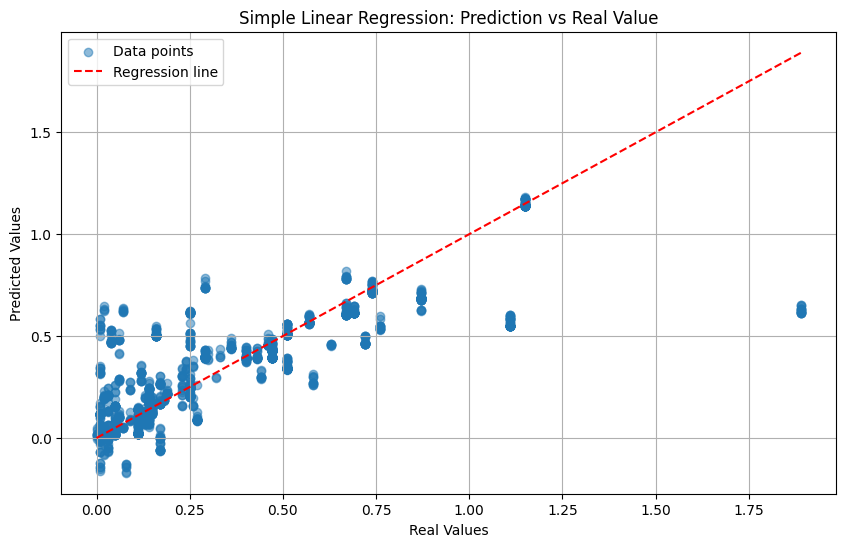

In [3]:
import numpy as np
import matplotlib.pyplot as plt


# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Data points')

# 绘制线性回归线
#plt.plot(y_test, slope * y_test + intercept, color='red', label='Regression line')
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', label='Regression line')
plt.grid(True)

# 添加标签和标题
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Simple Linear Regression: Prediction vs Real Value')
plt.legend()

plt.show()


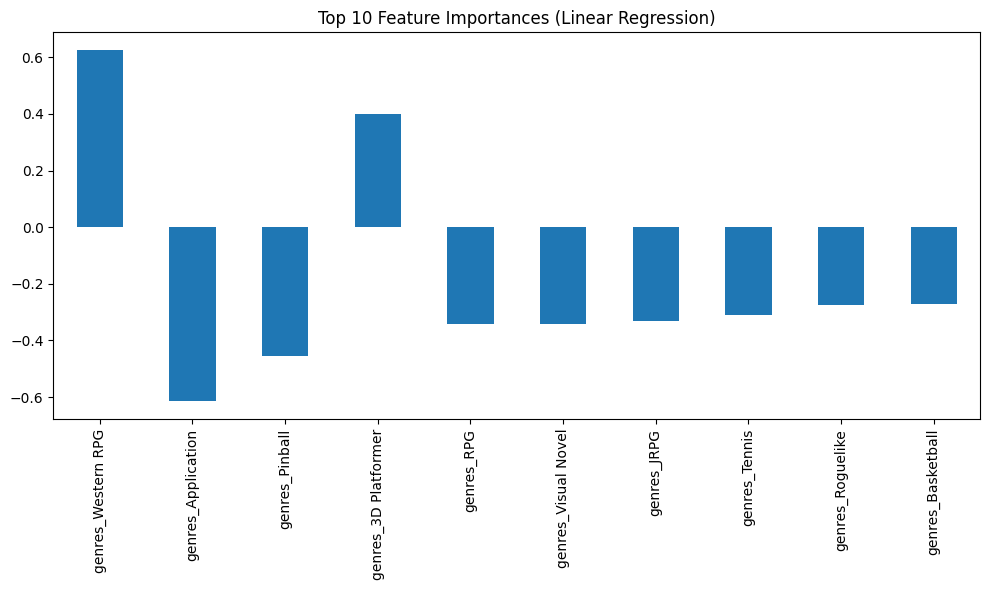

In [4]:
# Feature Importance of Linear Regression

# 获取线性回归模型的系数
importances = model.coef_
feature_names = X_test.columns

import pandas as pd
import matplotlib.pyplot as plt

# 创建一个包含特征重要性的 Series
feat_imp = pd.Series(importances, index=feature_names).sort_values(key=abs, ascending=False)

# 绘制前10个最重要的特征
feat_imp.head(10).plot(kind='bar', figsize=(10, 6), title='Top 10 Feature Importances (Linear Regression)')
plt.tight_layout()
plt.show()


In [5]:
'''
#2. Random Foreast and log-transformed 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# 轉換 log
import numpy as np
df['log_total_sales'] = np.log1p(df['total_sales'])  # log1p(x) = log(1 + x)


# Choose X, y coulmns
X = df.drop(['Unnamed: 0','title', 'quote', 'releaseDate', 'total_sales', 'processed_tokens',
              'clean_text_stemmed', 'clean_text_lemmatized', 'entities', 'frequency', 
              'sentiment', 'log_total_sales'], axis=1, errors='ignore')
X = pd.get_dummies(X, columns=['platform', 'rating', 'genres', 'predicted_sentiment'], drop_first=True)

y = df['log_total_sales'] 

print(X.shape)
# Impute Missing value for X??
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Spilt data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Modeling : RandomForest
model = RandomForestRegressor(random_state=42)

# RMSE definition : --> cross_ val_score does not have RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Cross_validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)
# Cross-validation with R² scoring
cv_r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# fit the model
model.fit(X_train, y_train)

# Prediction and Evaluation
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # 將 log 還原回原始銷售值
y_test_original = np.expm1(y_test)  # 把 y_test 也還原以便計算 RMSE

# Step 10: 評估
print(f"\nModel1.1: RandomForestRegressor (log-transformed target)")
print(f"Cross-Validation RMSE scores: {cv_scores}")
print("Test RMSE:", mean_squared_error(y_test_original, y_pred, squared=False))



# Print the R² scores
print("Cross-validated R² scores:", cv_r2_scores)
print("Mean R² score:", cv_r2_scores.mean())
'''

'\n#2. Random Foreast and log-transformed \nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.metrics import make_scorer, mean_squared_error\n\n# 轉換 log\nimport numpy as np\ndf[\'log_total_sales\'] = np.log1p(df[\'total_sales\'])  # log1p(x) = log(1 + x)\n\n\n# Choose X, y coulmns\nX = df.drop([\'Unnamed: 0\',\'title\', \'quote\', \'releaseDate\', \'total_sales\', \'processed_tokens\',\n              \'clean_text_stemmed\', \'clean_text_lemmatized\', \'entities\', \'frequency\', \n              \'sentiment\', \'log_total_sales\'], axis=1, errors=\'ignore\')\nX = pd.get_dummies(X, columns=[\'platform\', \'rating\', \'genres\', \'predicted_sentiment\'], drop_first=True)\n\ny = df[\'log_total_sales\'] \n\nprint(X.shape)\n# Impute Missing value for X??\nimputer = SimpleIm

In [6]:
# RandomForestRegressor (Orginal y)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# Orginal y 
y = df['total_sales']

# Choose X
X = df.drop(['Unnamed: 0','title', 'quote', 'releaseDate', 'total_sales', 'log_total_sales',
             'processed_tokens', 'clean_text_stemmed', 'clean_text_lemmatized',
             'entities', 'frequency', 'sentiment'], axis=1, errors='ignore')

# 
X = pd.get_dummies(X, columns=['platform', 'rating', 'genres', 'predicted_sentiment'], drop_first=True)

print("X shape:", X.shape)

# Imputation
#imputer = SimpleImputer(strategy='median')
#X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split dataset
#X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Model definition
model_rf = RandomForestRegressor(random_state=42)

# Cross-validation: RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)
cv_scores = cross_val_score(model_rf, X_train, y_train, cv=5, scoring=rmse_scorer)

# Cross-validation: R²
cv_r2_scores = cross_val_score(model_rf, X_train, y_train, cv=5, scoring='r2')

# fit the mode
model_rf.fit(X_train, y_train)

# Prediction
y_pred = model_rf.predict(X_test)

# Model evaluation
print(f"\nModel2: RandomForestRegressor (original target)")
print(f"Cross-Validation RMSE scores in training set: {cv_scores}")
print("Mean RMSE in training set:", cv_scores.mean())
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("-----------------------------------------------")
print("Cross-validated R² scores:", cv_r2_scores)
print("Mean R² score in training set:", cv_r2_scores.mean())
print("R² score in testing set:", r2_score(y_test, model_rf.predict(X_test)))



X shape: (6208, 50)

Model2: RandomForestRegressor (original target)
Cross-Validation RMSE scores in training set: [0.0011125  0.00056641 0.00258277 0.00149466 0.00210039]
Mean RMSE in training set: 0.0015713462532642984
Test RMSE: 0.0011650045671320454
-----------------------------------------------
Cross-validated R² scores: [0.99998899 0.99999718 0.99994575 0.99997892 0.9999622 ]
Mean R² score in training set: 0.9999746087843094
R² score in testing set: 0.9999887010716677


In [7]:
# save the model


import joblib
# Save model, imputer, and model features
joblib.dump(model_rf, 'Model/rf_model2.pkl')
#joblib.dump(imputer, 'Model/imputer2.pkl')
joblib.dump(X.columns.to_list(), 'Model/model_features2.pkl')
print('Finish :save models!')

Finish :save models!


In [8]:
# RandomForestRegressor (Orginal y)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV

# 不做 log 轉換，直接使用原始 total_sales
y = df['total_sales']

# 選擇 X 特徵
X = df.drop(['Unnamed: 0','title', 'quote', 'releaseDate', 'total_sales', 'log_total_sales',
             'processed_tokens', 'clean_text_stemmed', 'clean_text_lemmatized',
             'entities', 'frequency', 'sentiment'], axis=1, errors='ignore')

# 類別變數轉換
X = pd.get_dummies(X, columns=['platform', 'rating', 'genres', 'predicted_sentiment'], drop_first=True)

print("X shape:", X.shape)

# 補缺值
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 切分訓練與測試資料
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [100,200],
    'max_depth': [10,15 ],
    'min_samples_split': [ 2,5],
    'min_samples_leaf': [1,5],
    'max_features': ['log2']
}

# 模型定義
rf = RandomForestRegressor(random_state=42)
print( "Model3: RandomForestRegressor")
# 定義 RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# 設定 GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                       # 5-fold cross validation
    scoring=rmse_scorer,        # 使用 RMSE 當作評估標準
    n_jobs=-1,                  # 平行處理所有核心
    verbose=0                   # 印出訓練過程
)
grid_search.fit(X_train, y_train)

print("Best RMSE Score in training set:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

# 获取交叉验证结果
cv_results = grid_search.cv_results_

# 打印每个参数组合及其得分
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print("Parameters: %s" % params)
    print("Mean RMSE in training set: %0.4f" % mean_score)
    


print("-----------------------------------------------")
# 使用最佳参数重新預測
best_rf = grid_search.best_estimator_
print('best_rf:',best_rf)
# 在测试集上进行预测
y_pred = best_rf.predict(X_test)


RMSE_test = mean_squared_error(y_test, best_rf.predict(X_test), squared=False)
print("RMSE in testing set:", RMSE_test)


cv_r2_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')
# 计算并打印 R² 分数
print("Mean R² score in training set:", cv_r2_scores.mean())
# test dataset for R2 score
print("R² score in testing set:", r2_score(y_test, best_rf.predict(X_test)))

X shape: (6208, 50)
Model3: RandomForestRegressor
Best RMSE Score in training set: 0.1416644291650724
Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean RMSE in training set: 0.1212
Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean RMSE in training set: 0.1176
Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mean RMSE in training set: 0.1218
Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mean RMSE in training set: 0.1195
Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
Mean RMSE in training set

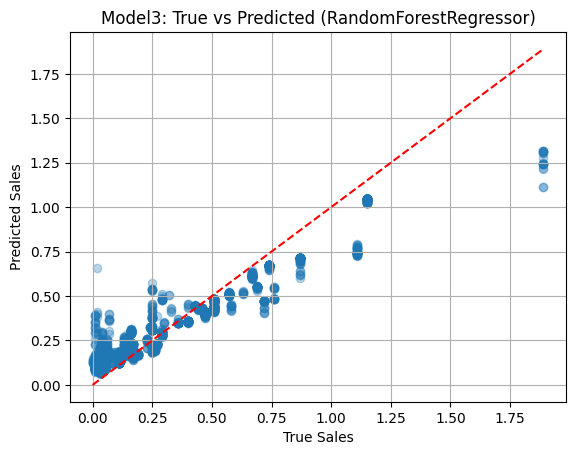

In [9]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('True Sales')
plt.ylabel('Predicted Sales')
plt.title('Model3: True vs Predicted (RandomForestRegressor)')
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.grid(True)
plt.show()


In [10]:
# Test: Save the model

"""
import joblib
# Save model, imputer, and model features
joblib.dump(model, 'Model/rf_model.pkl')
joblib.dump(imputer, 'Model/imputer.pkl')
joblib.dump(X.columns.to_list(), 'Model/model_features.pkl')
print('Finish :save models!')
"""


import joblib
# Save model, imputer, and model features
joblib.dump(best_rf, 'Model/rf_model.pkl') #best model of random foreast
joblib.dump(imputer, 'Model/imputer.pkl')
joblib.dump(X.columns.to_list(), 'Model/model_features.pkl')
print('Finish :save models!')


# Keras
#model.save('model.h5')
#model = keras.models.load_model('model.h5')


Finish :save models!


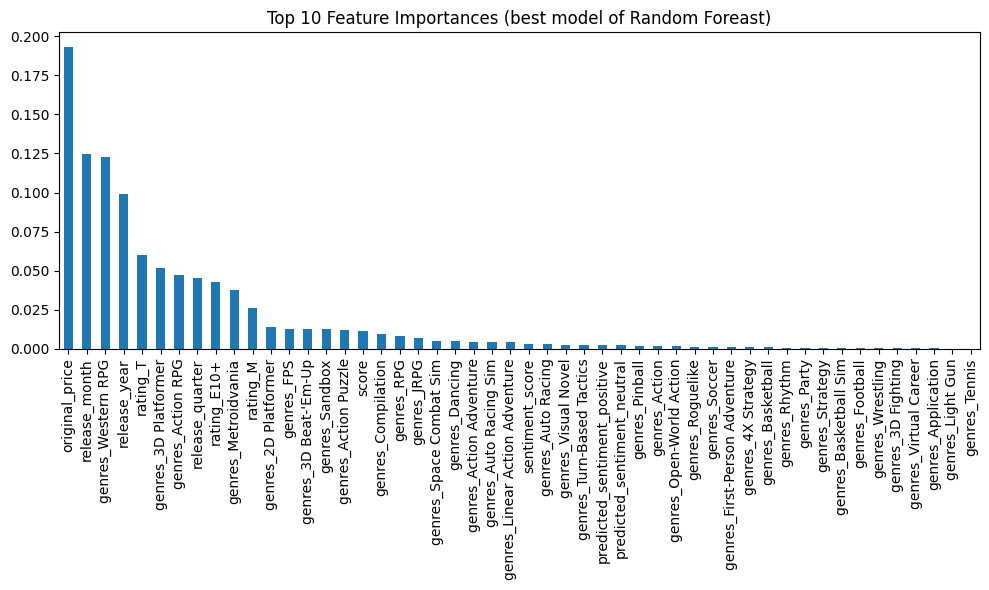

In [11]:
# # Feature Importance of Random Foreast

importances = best_rf.feature_importances_
feature_names = X_test.columns


import pandas as pd
import matplotlib.pyplot as plt


# Create a Series with feature importances
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot the top 10 features
feat_imp.head(100).plot(kind='bar', figsize=(10, 6), title='Top 10 Feature Importances (best model of Random Foreast)')
plt.tight_layout()
plt.show()

In [12]:
# model2 : MLP

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns



# 選擇 X 特徵
X = df.drop(['Unnamed: 0','title', 'quote', 'releaseDate', 'total_sales', 'log_total_sales',
             'processed_tokens', 'clean_text_stemmed', 'clean_text_lemmatized',
             'entities', 'frequency', 'sentiment'], axis=1, errors='ignore')

# 類別變數轉換
X = pd.get_dummies(X, columns=['platform', 'rating', 'genres', 'predicted_sentiment'], drop_first=True)

# Standardize
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

print(X_scaled.head())


# split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)




# grid search by using different hyper-paramenter
from itertools import product

# Hyper Paramenter setting
architectures = [(64,), (100, 50)]
learning_rates = [0.001, 0.01]
alphas = [0.0001, 0.001, 0.01, 0.1]  # add L2 regularization
activations = ['relu', 'tanh']
'''
# Hyper Paramenter setting
architectures = [(64,)]
learning_rates = [0.001]
alphas = [ 0.1]  # add L2 regularization
activations = ['relu']
'''
# 用 itertools.product grid 
param_grid = [
    {'arch': arch, 'lr': lr, 'alpha': alpha, 'act': act}
    for arch, lr, alpha, act in product(architectures, learning_rates, alphas, activations)
]



results = []
# 存储所有 MLP 模型的分数
mlp_scores = []


for i, params in enumerate(param_grid, start=1):
    # Create Models
    model_mlp = MLPRegressor(
            hidden_layer_sizes=params['arch'],
            activation=params['act'],
            solver='adam',
            learning_rate_init=params['lr'],
            alpha=params['alpha'],
            max_iter=1000,
            early_stopping=True,
            random_state=42
        )

   # CV RMSE
    cv_rmse = cross_val_score(model_mlp, X_train, y_train, cv=5,
                              #scoring=make_scorer(mean_squared_error, squared=False)).mean()
                            scoring='r2').mean()
    #training and testing
    model_mlp.fit(X_train, y_train)
    y_pred = model_mlp.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    train_r2 = r2_score(y_train, model_mlp.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)

    # Print Result
    results.append({
        'MLP_Model_id': i,  # Add the model ID here
        'Architecture': str(params['arch']),
        'Learning Rate': params['lr'],
        'Alpha': params['alpha'],
        'Activation': params['act'],
        'CV RMSE': round(cv_rmse, 4),
        'Test RMSE': round(test_rmse, 4),
        'Train R²': round(train_r2, 4),
        'Test R²': round(test_r2, 4)
    })

    # 计算每个模型的交叉验证 R² 分数
    scores = cross_val_score(model_mlp, X_train, y_train, cv=5, scoring='r2')
    mlp_scores.extend([(f'MLP Model {i}', score) for score in scores])



# Print it as a table 
results_df = pd.DataFrame(results).sort_values(by='Test R²')
display(results_df)






      score  original_price  release_year  release_quarter  release_month  \
0  0.654013        0.190399     -0.524492         1.046068       0.790969   
1  0.574141        0.190399     -0.524492         1.046068       0.790969   
2 -0.144703       -1.732884     -0.524492         0.006531       0.409436   
3  0.654013       -0.392414      0.142184        -1.033007      -1.116698   
4  1.053371        1.356026      0.142184         1.046068       1.172502   

   sentiment_score  rating_E10+  rating_M  rating_T  genres_2D Platformer  \
0         0.466006    -0.741140  2.679400 -0.733592             -0.351596   
1         0.466006    -0.741140  2.679400 -0.733592             -0.351596   
2         0.466006     1.349272 -0.373218 -0.733592             -0.351596   
3        -2.425511    -0.741140 -0.373218  1.363156             -0.351596   
4         0.466006    -0.741140  2.679400 -0.733592             -0.351596   

   ...  genres_Space Combat Sim  genres_Strategy  genres_Tennis  \
0  ... 

,MLP_Model_id,Architecture,Learning Rate,Alpha,Activation,CV RMSE,Test RMSE,Train R²,Test R²
14,15,"(64,)",0.010,0.1000,relu,0.9216,0.0809,0.9494,0.9455
31,32,"(100, 50)",0.010,0.1000,tanh,0.9709,0.0658,0.9646,0.9639
15,16,"(64,)",0.010,0.1000,tanh,0.9662,0.0585,0.9717,0.9715
7,8,"(64,)",0.001,0.1000,tanh,0.9670,0.0489,0.9818,0.9801
6,7,"(64,)",0.001,0.1000,relu,0.9803,0.0488,0.9852,0.9802
0,1,"(64,)",0.001,0.0001,relu,0.9670,0.0472,0.9905,0.9814
16,17,"(100, 50)",0.001,0.0001,relu,0.9749,0.0463,0.9946,0.9821
20,21,"(100, 50)",0.001,0.0100,relu,0.9783,0.0426,0.9949,0.9849
18,19,"(100, 50)",0.001,0.0010,relu,0.9758,0.0414,0.9963,0.9857
23,24,"(100, 50)",0.001,0.1000,tanh,0.9864,0.0406,0.9877,0.9863


In [17]:
# Only select top 5 in result_df
results_df_top5 = results_df.head(5)

# 选择倒数 5 行
#results_df_top5 = results_df.tail(5)
results_df_top5

,MLP_Model_id,Architecture,Learning Rate,Alpha,Activation,CV RMSE,Test RMSE,Train R²,Test R²
14,15,"(64,)",0.010,0.1,relu,0.9216,0.0809,0.9494,0.9455
31,32,"(100, 50)",0.010,0.1,tanh,0.9709,0.0658,0.9646,0.9639
15,16,"(64,)",0.010,0.1,tanh,0.9662,0.0585,0.9717,0.9715
7,8,"(64,)",0.001,0.1,tanh,0.9670,0.0489,0.9818,0.9801
6,7,"(64,)",0.001,0.1,relu,0.9803,0.0488,0.9852,0.9802


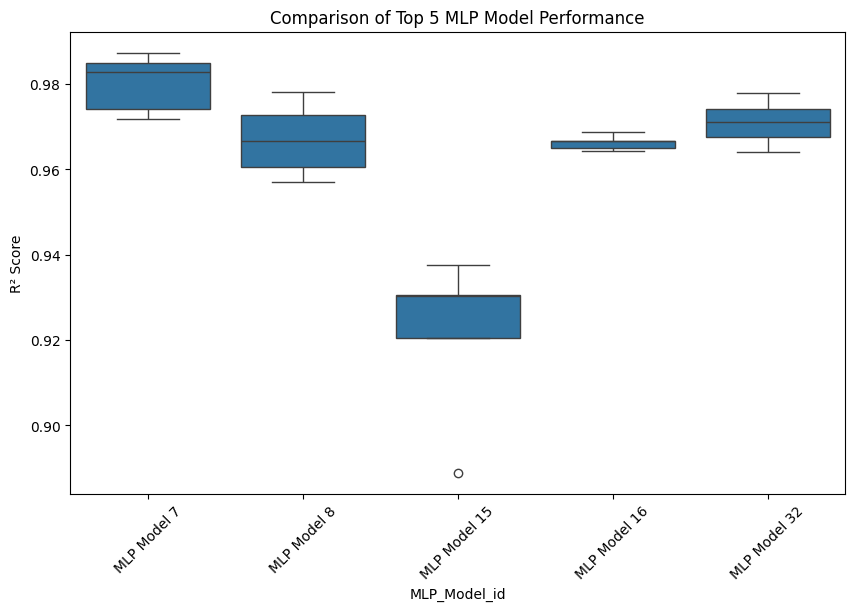

In [20]:
# Only select top 5 in result_df
results_df_top5 = results_df.head(5)


# 從 mlp_scores 中篩選出對應於 results_df_top5 的模型分數
top5_ids = results_df_top5['MLP_Model_id'].tolist()
filtered_scores = [(model, score) for model, score in mlp_scores if int(model.split()[-1]) in top5_ids]

# 創建一個 DataFrame 來存儲這些分數
score_data = pd.DataFrame(filtered_scores, columns=['MLP_Model_id', 'R² Score'])

# 繪製箱形圖
plt.figure(figsize=(10, 6))
sns.boxplot(x='MLP_Model_id', y='R² Score', data=score_data)
plt.xticks(rotation=45)
plt.title('Comparison of Top 5 MLP Model Performance')
plt.show()

According to the result of NLP models, the test set R2 are around 0.90 ~0.99.


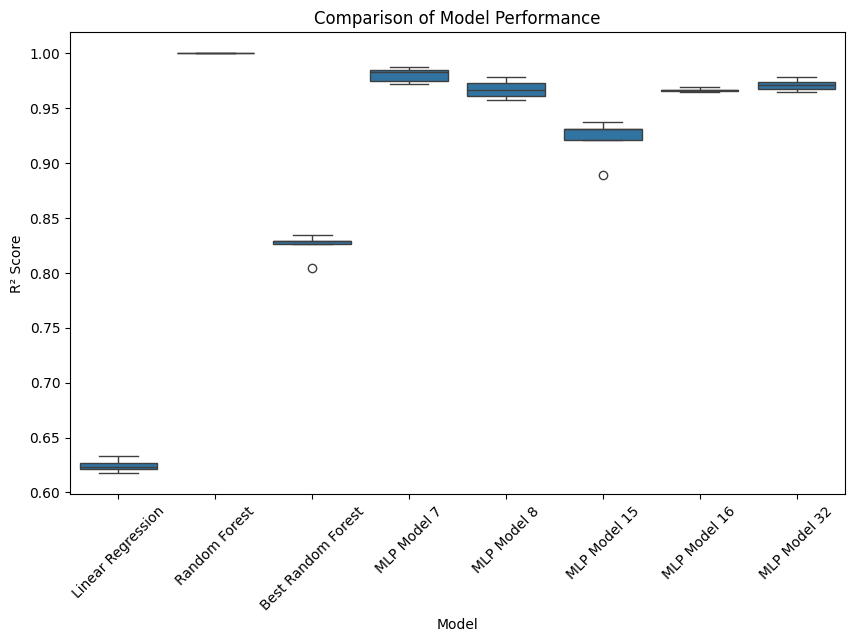

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 3模型的交叉验证 R² 分数
linear_model_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
rf_model_scores = cross_val_score(model_rf, X_train, y_train, cv=5, scoring='r2')
rf_best_model_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')

test_r2_scores = []

# 创建一个 DataFrame 来存储这些分数
import pandas as pd
data = pd.DataFrame({
    'Model': ['Linear Regression'] * len(linear_model_scores) + ['Random Forest'] * len(rf_model_scores) 
    + ['Best Random Forest'] * len(rf_best_model_scores),
    'R² Score': np.concatenate([linear_model_scores, rf_model_scores, rf_best_model_scores])
})

# 將 'MLP_Model_id' 重命名為 'Model' 以便合併
score_data = score_data.rename(columns={'MLP_Model_id': 'Model'})

# 合併 score_data 到 data
combined_data = pd.concat([data, score_data], ignore_index=True)


# 绘制箱线图
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='R² Score', data=combined_data)
plt.title('Comparison of Model Performance')
plt.xticks(rotation=45)
plt.show()

#### To choose the best model
After comparing the R² scores of all models, Random Forest was chosen as the final model for predicting game sales. Among all tested models, Random Forest achieved a consistently high R² score with minimal variance and no significant outliers, demonstrating both strong accuracy and stability. Although some MLP models reached similar or slightly higher R² scores, they showed greater variability, which could indicate potential overfitting or sensitivity to data splits. In contrast, Random Forest offers a good balance between predictive performance and interpretability, and it is more computationally efficient. Given its reliability and consistent performance, Random Forest is the most suitable model for this task.